# Energies and logits

Results referenced in 25b_Section_2_research.ipynb.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
def get_energy_logits_df(fp, fp_test_1, fp_test_2):

    df_test_1 = pd.read_csv(fp_test_1, sep="\t")
    df_test_1["class"] = "positive"
    df_test_2 = pd.read_csv(fp_test_2, sep="\t")
    df_test_2["class"] = "negative"
    df_test = pd.concat([df_test_1, df_test_2], axis=0)

    with open(fp, "r") as f:
        data = json.load(f)
    df = pd.DataFrame.from_records(data)

    df_kd = pd.read_csv("01b_df_kd.csv")


    df = pd.merge(df, df_test, left_on="slide", right_on="Slide")
    df = pd.merge(df, df_kd, left_on="slide", right_on="cdr3", how="left")
    return df


In [3]:
paths = {
    "vs Weak": {
        "fp": "../data/Frozen_MiniAbsolut_ML/high_vs_looser/seed_0/split_42/HR2P_high__vs__HR2P_looser/attributions/v2.0-2/attribution_records.json",
        "fp_test_1": "../data/MiniAbsolut/HR2P/high_test_500.tsv",
        "fp_test_2": "../data/MiniAbsolut/HR2P/looserX_test_500.tsv",
    },

    "vs Non-binder": {
        "fp": "../data/Frozen_MiniAbsolut_ML/high_vs_95low/seed_0/split_42/HR2P_high__vs__HR2P_95low/attributions/v2.0-2/attribution_records.json",
        "fp_test_1": "../data/MiniAbsolut/HR2P/high_test_500.tsv",
        "fp_test_2": "../data/MiniAbsolut/HR2P/95low_test_500.tsv",
    },

    "vs Randomized": {
        "fp": "../data/Frozen_MiniAbsolut_ML/1v1/seed_0/split_42/HR2P__vs__HR2PIR/attributions/v2.0-2/attribution_records.json",
        "fp_test_1": "../data/MiniAbsolut/HR2P/high_test_500.tsv",
        "fp_test_2": "../data/MiniAbsolut/HR2PSR/high_test_5000.tsv",
    },
    
}

/tmp/ipykernel_1737274/2680664127.py:18: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1737274/2680664127.py:18: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1737274/2680664127.py:18: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.scatterplot(


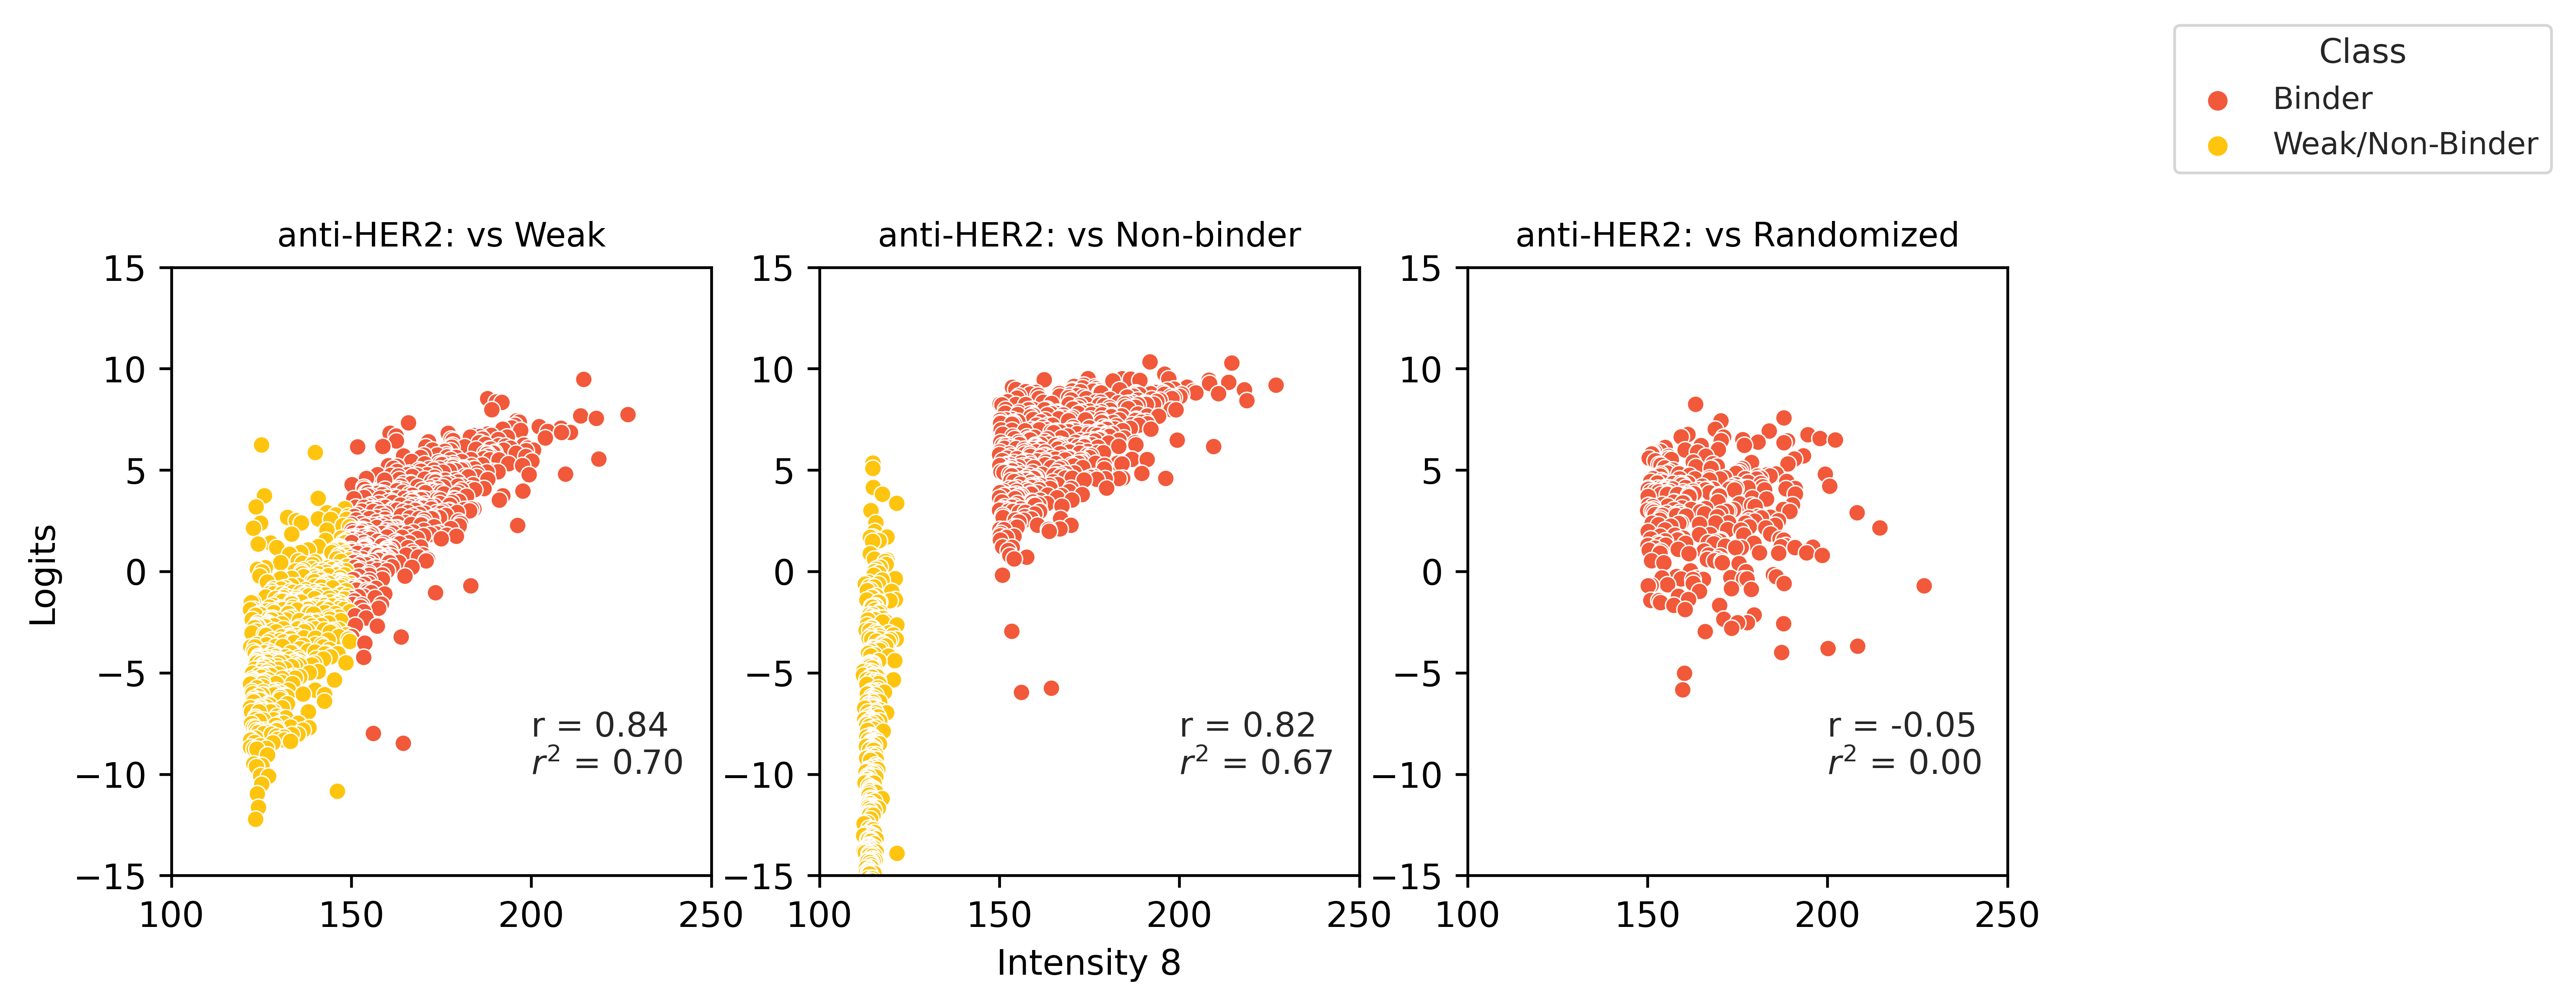

In [4]:
fig, axs = plt.subplots(ncols=3, figsize=(3*3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

col_to_corr = "intensity 8"

cmap = [
    "#f1593a", # red
    "#ffc40d", # yellow
    "#28a3dc", # blue
]

for i, (task_i, paths_i) in enumerate(paths.items()):

    df = get_energy_logits_df(paths_i["fp"], paths_i["fp_test_1"], paths_i["fp_test_2"])
    ax = axs[i]

    sns.scatterplot(
        data=df,
        x=col_to_corr,
        y="logits",
        hue="class",
        ax=ax,
        palette=cmap,
    )

    ax.set_xlim((100, 250))
    ax.set_ylim((-15, 15))

    ax.set_xlabel("")
    ax.set_ylabel("")
    
    if i == 1:
        ax.set_xlabel("Intensity 8")
    if i == 0:
        ax.set_ylabel("Logits")
    
    ax.set_title(f"anti-HER2: {task_i}")
    # ax.set_xticks(np.arange(-110, -89, 5))

    # Add a coefficient of correlation and coeficient of determination
    r, p = pearsonr(
        df[col_to_corr].loc[df[col_to_corr].notna()], 
        df["logits"].loc[df[col_to_corr].notna()],
        )
    r2 = r ** 2
    ax.text(
        200,
        -10,
        f"r = {r:.2f}\n$r^2$ = {r2:.2f}",
        bbox=dict(facecolor="white", alpha=0.5),
    )
    # Remove legend from ax
    ax.get_legend().remove()

# Add legend with legend title
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=["Binder", "Weak/Non-Binder"],
    title="Class",
    loc="lower center",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0,
)

Energy contributions ~ Attributions correlations

In [5]:
from utils_07 import get_attr_from_records, get_onehotstack_from_records
from utils_07 import load_energy_contributions_from_task_nonlinear_version

Note: 1v1 here, for experimental, means just HR2P vs HR2PSR (sequence randomized).

In [6]:
task_types= [
    datasets.ClassificationTaskType.ONE_VS_ONE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
]

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)

FORCE_RUN = True
df_path = Path("07e_df_attr_experimental.csv")

if df_path.exists() and not FORCE_RUN:
    df = pd.read_csv(df_path)
else:
    seed_id = 0
    split_id = 42
    attributor_name = "DeepLIFT_LOCAL_v2.0-2"
    dfs = []
    for ag in ["HR2P"]:
        
        df = pd.DataFrame()
        for task_type in task_types:   

            if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag,
                    ag_neg="HR2PSR",
                    seed_id=seed_id,
                    split_id=split_id,
                )
            else:
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
            
            task = loader.load(task, attributions_toload="v2.0-2", load_model=True)

            attr_stack = get_attr_from_records(
                task.attributions, attributor_name, (0, 1)  # type: ignore
            )  # Nx11x20 # type: ignore
            onehot_stack = get_onehotstack_from_records(
                task.attributions, (0, 1)  # type: ignore
            )  # Nx220 # type: ignore
            attr_aa = attr_stack[onehot_stack.reshape((-1, 21, 20)) == 1].reshape(
                -1, 21
            )  # Nx11

            
            df_i = pd.DataFrame.from_records(task.attributions)
            df_i["ag"] = ag
            col_aa = f"attr_aa_{task.task_type.to_str()}"
            col_logits = f"logits_{task.task_type.to_str()}"
            df_i[col_aa] = [arr for arr in attr_aa]
            df_i[col_logits] = df_i["logits"]
            

            df_i.query("y_true == 1", inplace=True)
            df_i = df_i[["slide", "ag", col_aa, col_logits, "L1_complexity", "L2_complexity", "SN10_complexity"]]

            if df.shape[0] == 0:
                df = df_i
            else:
                df = pd.merge(df, df_i, on=["slide", "ag"], how="inner")
        dfs.append(df)

    df = pd.concat(dfs, axis=0)
    df = df.reset_index(drop=True)
    df.to_csv(df_path, index=False)

KeyError: "['L1_complexity', 'L2_complexity', 'SN10_complexity'] not in index"

In [ ]:
def process_str_to_list_floats(s):
    vals = []
    for ch in s.replace("\n", "").strip("[] ").split(" "):
        if ch == "":
            continue
        vals.append(float(ch))
    assert len(vals) == 21
    return vals

if type(df["attr_aa_high_vs_looser"][0][0]) is not np.float64:
    df["attr_aa_high_vs_looser"] = df["attr_aa_high_vs_looser"].apply(process_str_to_list_floats) 
    df["attr_aa_high_vs_95low"] = df["attr_aa_high_vs_95low"].apply(process_str_to_list_floats)
    df["attr_aa_1v1"] = df["attr_aa_1v1"].apply(process_str_to_list_floats)

In [ ]:
df["corr_attr_losser_95low"] = df.apply(lambda row: pearsonr(row["attr_aa_high_vs_looser"], row["attr_aa_high_vs_95low"])[0], axis=1)
df["corr_attr_9_looser"] = df.apply(lambda row: pearsonr(row["attr_aa_1v1"], row["attr_aa_high_vs_looser"])[0], axis=1) 
df["corr_attr_9_95low"] = df.apply(lambda row: pearsonr(row["attr_aa_1v1"], row["attr_aa_high_vs_95low"])[0], axis=1)

In [ ]:
# Melt df across correlations
df_corr = df[["slide", "ag", "corr_attr_losser_95low", "corr_attr_9_looser", "corr_attr_9_95low", "L1_complexity", "L2_complexity", "SN10_complexity"]]
df_corr = df_corr.melt(id_vars=["slide", "ag"], var_name="corr_type", value_name="corr_value")
df_corr

,slide,ag,corr_type,corr_value
0,HDVGYCDTPNCAKWPEYFQHW,HR2P,corr_attr_losser_95low,0.419568
1,HDVGQCDTPTCAKWPEYFQHW,HR2P,corr_attr_losser_95low,0.450543
2,HDVGYCSSSRCATWPEYFQHW,HR2P,corr_attr_losser_95low,0.451795
3,HDVGYCDSSRCLTWPEYFQHW,HR2P,corr_attr_losser_95low,0.357278
4,HDVGYCSSPRCLTWPEYFQHW,HR2P,corr_attr_losser_95low,0.342386
...,...,...,...,...
2995,HDVDYCSDLRCLTWPEYFKFW,HR2P,SN10_complexity,tensor(26.6910)
2996,HEVAYCDTPTCDDWDEYFQHW,HR2P,SN10_complexity,tensor(26.6910)
2997,HDVDHCESDRCLTWPEYLQHW,HR2P,SN10_complexity,tensor(26.6910)
2998,HDVGDCDSDDCAMWPEYFCHW,HR2P,SN10_complexity,tensor(26.6910)


<AxesSubplot: xlabel='ag', ylabel='corr_value'>

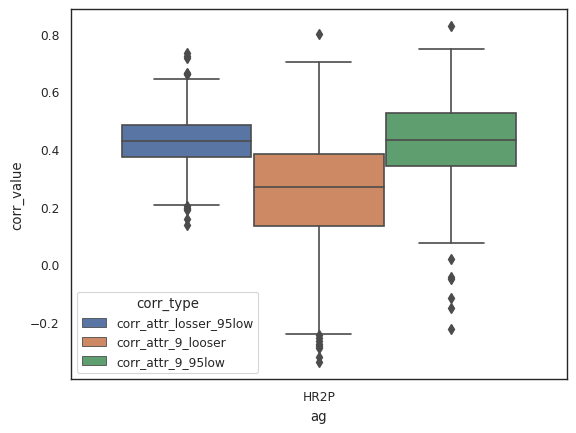

In [ ]:
sns.boxplot(
    data=df_corr,
    x="ag",
    y="corr_value",
    hue="corr_type",
)

In [ ]:
df["attr_aa_high_vs_looser"].apply(lambda x: np.linalg.norm(x, ord=2))

0      5.128563
1      5.112557
2      4.553996
3      4.665377
4      4.573494
         ...   
495    4.364342
496    4.599831
497    3.786159
498    5.934044
499    6.721246
Name: attr_aa_high_vs_looser, Length: 500, dtype: float64

<AxesSubplot: xlabel='attr_type', ylabel='attr_value'>

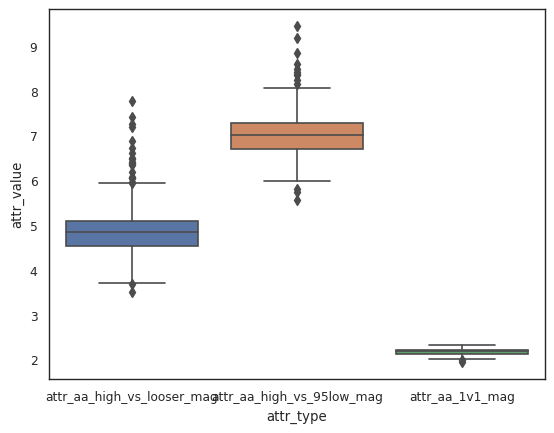

In [ ]:
## Magnitude of attributions
df["attr_aa_high_vs_looser_mag"] = df["attr_aa_high_vs_looser"].apply(lambda x: np.linalg.norm(x, ord=2))
df["attr_aa_high_vs_95low_mag"] = df["attr_aa_high_vs_95low"].apply(lambda x: np.linalg.norm(x, ord=2))
df["attr_aa_1v1_mag"] = df["attr_aa_1v1"].apply(lambda x: np.linalg.norm(x, ord=2))

df_mag = df[["slide", "ag", "attr_aa_high_vs_looser_mag", "attr_aa_high_vs_95low_mag", "attr_aa_1v1_mag"]]
df_mag = df_mag.melt(id_vars=["slide", "ag"], var_name="attr_type", value_name="attr_value")
sns.boxplot(
    data=df_mag,
    x="attr_type",
    y="attr_value",
)

Model complexity

In [ ]:
seed_id = 0
split_id = 42
attributor_name = "DeepLIFT_LOCAL_v2.0-2"
records = []
for ag in ["HR2P"]:
    
    df = pd.DataFrame()
    for task_type in task_types:   

        if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
            task = datasets.ClassificationTask(
                task_type=task_type,
                ag_pos=ag,
                ag_neg="HR2PSR",
                seed_id=seed_id,
                split_id=split_id,
            )
        else:
            task = datasets.ClassificationTask(
                task_type=task_type,
                ag_pos=ag,
                ag_neg="auto",
                seed_id=seed_id,
                split_id=split_id,
            )
        
        task = loader.load(task, attributions_toload="v2.0-2", load_model=True)

        # Add model complexity
        L1_norm = task.state_dict["module.linear_1.weight"].norm()
        L2_norm = task.state_dict["module.linear_2.weight"].norm()
        records.append({
            "ag": ag,
            "task_type": task_type.to_str(),
            "L1_norm": L1_norm,
            "L2_norm": L2_norm,
            "SN10_norm": L1_norm + L2_norm,
        })


In [ ]:
records

[{'ag': 'HR2P',
  'task_type': '1v1',
  'L1_norm': tensor(9.2113),
  'L2_norm': tensor(1.5574),
  'SN10_norm': tensor(10.7688)},
 {'ag': 'HR2P',
  'task_type': 'high_vs_95low',
  'L1_norm': tensor(23.5224),
  'L2_norm': tensor(4.4771),
  'SN10_norm': tensor(27.9995)},
 {'ag': 'HR2P',
  'task_type': 'high_vs_looser',
  'L1_norm': tensor(22.1388),
  'L2_norm': tensor(4.5522),
  'SN10_norm': tensor(26.6910)}]

Plotting individual energy contributions correlations

Note: possible only after results from Puneet, for Brij dataset only!

In [ ]:
def plot_energy_contributions_per_task(task, slide_class = "positive", plot_perc = False, ax = None):
    _, slide_df = load_energy_contributions_from_task_nonlinear_version(task, load_slide_df=True)
    all_energies = []
    all_energies_perc = []
    all_attrs = []
    all_attrs_perc = []

    for i, row in slide_df.iterrows():
        if row["class"] != slide_class:
            continue
        energies = row["energies"]
        all_energies += energies
        all_energies_perc += (np.array(energies) / np.sum(energies)).tolist()

        attrs = row["attributions"]
        all_attrs += attrs.tolist()
        all_attrs_perc += (np.array(attrs) / np.sum(np.abs(attrs))).tolist()

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    if plot_perc:
        ax.plot(
            all_attrs_perc, 
            all_energies_perc, 
            'o', 
            alpha=0.1,
            color="#f1593a", # red
            )
    else:
        ax.plot(all_attrs, all_energies, 'o', alpha=0.1)

    # Compute correlation and add text

    r, p = pearsonr(all_energies_perc, all_attrs_perc)
    r2 = r ** 2
    ax.text(
        0.23,
        0.03,
        f"r = {r:.2f}\n$r^2$ = {r2:.2f}",
        bbox=dict(facecolor="white", alpha=0.5),
    )

In [ ]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#     ag_pos="5E94",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, ax=ax)
# ax.set_title("Energy contributions vs attributions for (5E94 vs 9)")

In [ ]:
sns.scatterplot(
    data=df,
    x="Energy",
    y="logits",
    hue="class",
    ax=ax,
    palette=cmap,
)

/tmp/ipykernel_1363179/3403770409.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


<AxesSubplot: xlabel='Task', ylabel='Pearson correlation coefficient'>

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Text(0.5, 0, 'Attribution (signed fraction)')

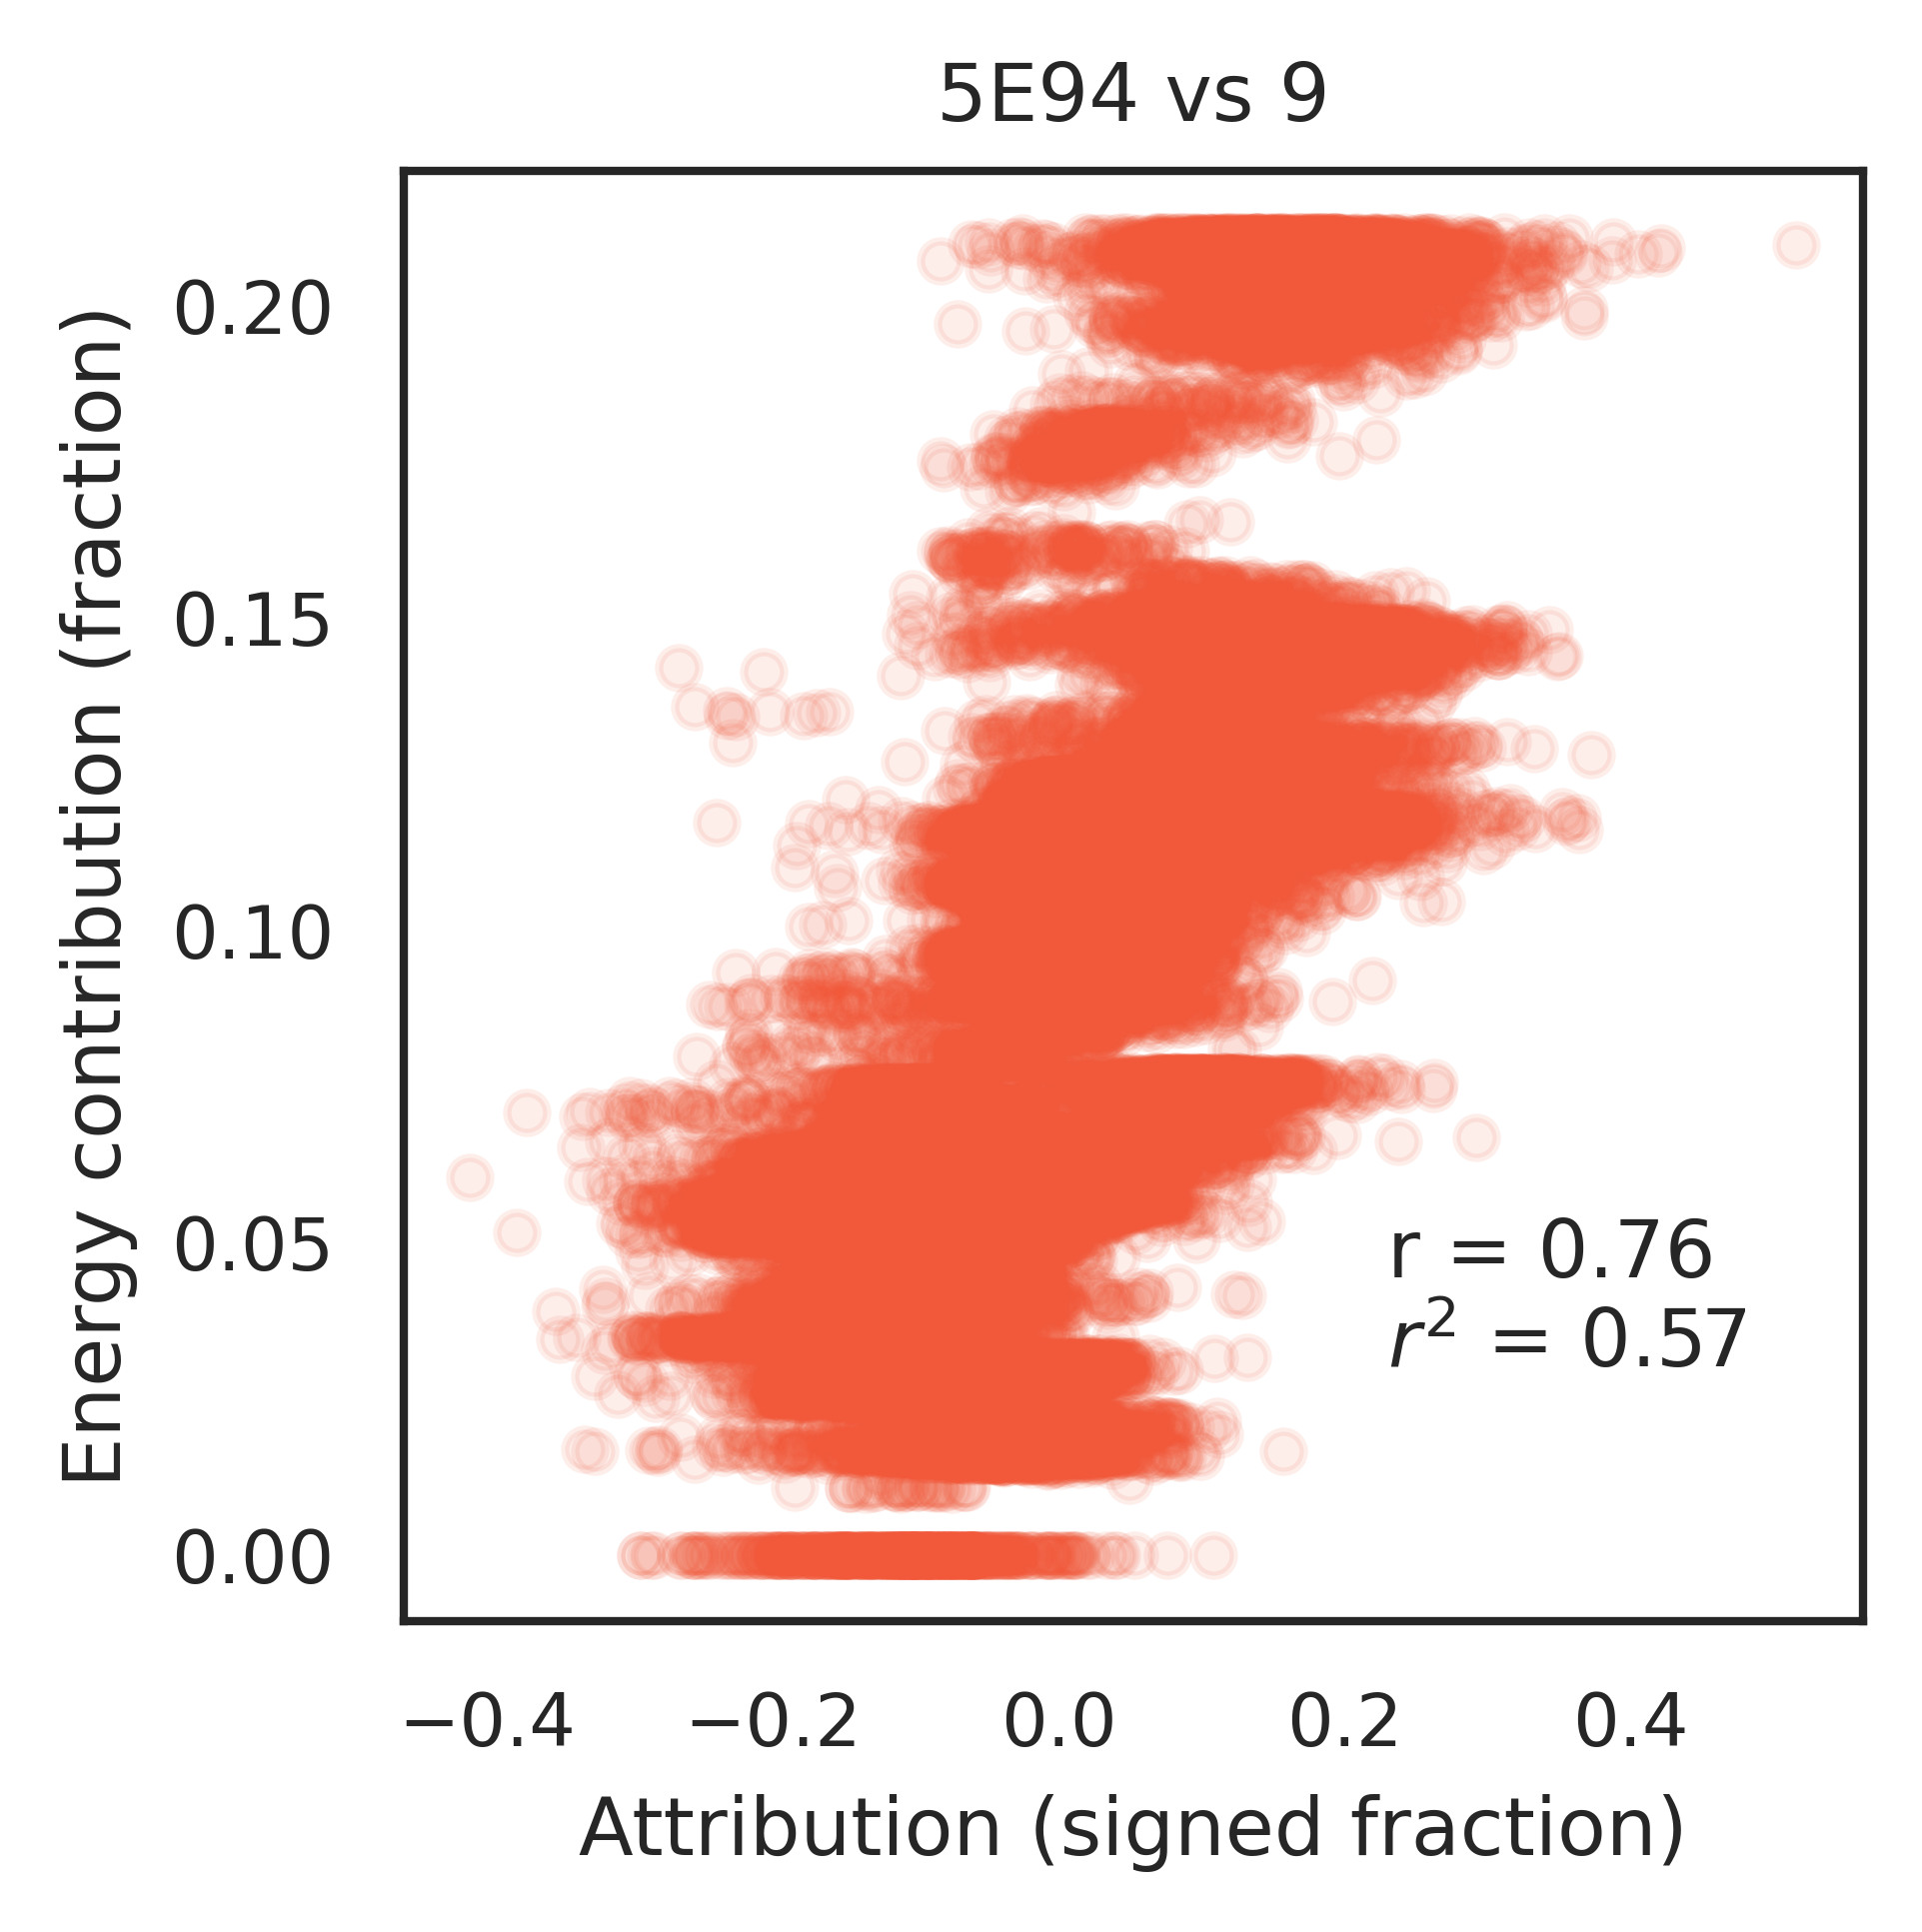

In [ ]:
task = datasets.ClassificationTask(
    task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
    ag_pos="5E94",
    ag_neg="auto",
    seed_id=0,
    split_id=0,
)

fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

cmap = ["#f1593a"]  # red

plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
ax.set_title("5E94 vs 9")
ax.set_ylabel("Energy contribution (fraction)")
ax.set_xlabel("Attribution (signed fraction)")

In [ ]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#     ag_pos="1NSN",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (1NSN vs 9)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

In [ ]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.HIGH_VS_LOOSER,
#     ag_pos="5E94",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (5E94 high vs looser)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

In [ ]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.HIGH_VS_LOOSER,
#     ag_pos="1NSN",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (1NSN high vs looser)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

Error analysis on AA Contributions

In [ ]:
task = datasets.ClassificationTask(
    task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
    ag_pos="5E94",
    ag_neg="auto",
    seed_id=0,
    split_id=42,
)
_, slide_df = load_energy_contributions_from_task_nonlinear_version(task, load_slide_df=True)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


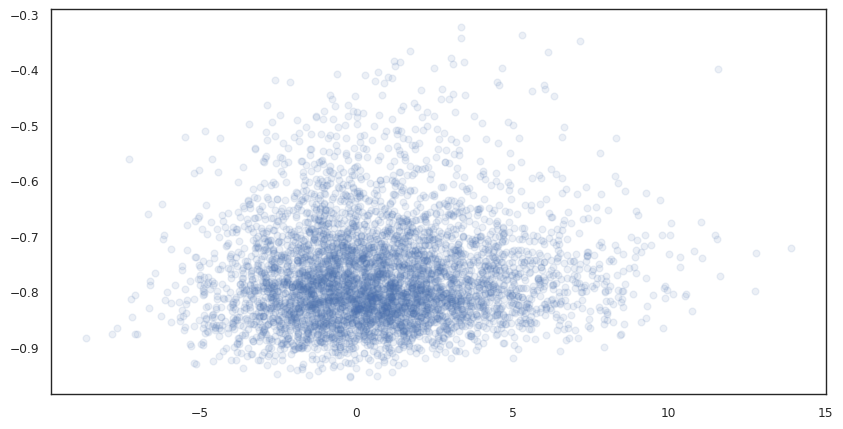

In [ ]:
slide_df["attributions_sum"] = slide_df["attributions"].apply(lambda x: np.sum(x))

# Plot r_total vs attributions_sum
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(slide_df["attributions_sum"], slide_df["r_total"], 'o', alpha=0.1)

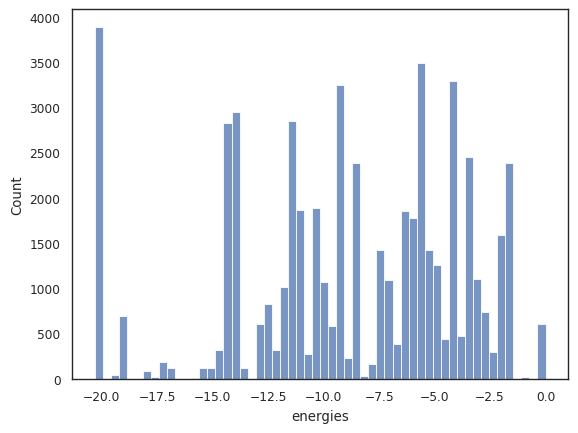

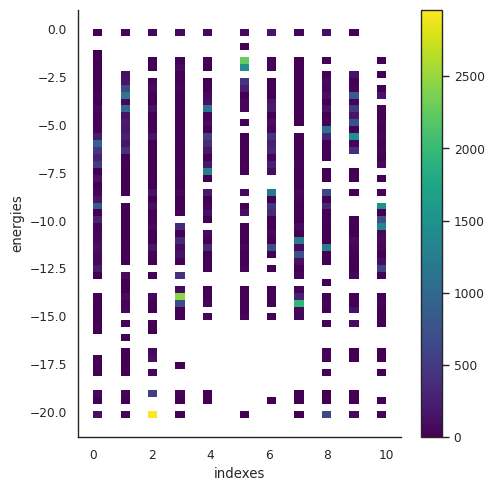

In [ ]:
# Collect all energies with indexes in list from slide_df and plot distribution
energies = []
indexes = []
for i, row in slide_df.iterrows():
    energies_i = row["energies"]
    energies += energies_i
    indexes_i = list(range(0, 11))
    indexes += indexes_i

sns.histplot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="energies",
)

sns.displot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="indexes",
    y="energies",
    cmap="viridis",
    rug=False,
    cbar=True,
)

In [ ]:
task = datasets.ClassificationTask(
    task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
    ag_pos="1NSN",
    ag_neg="auto",
    seed_id=0,
    split_id=42,
)
_, slide_df = load_energy_contributions_from_task_nonlinear_version(task, load_slide_df=True)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


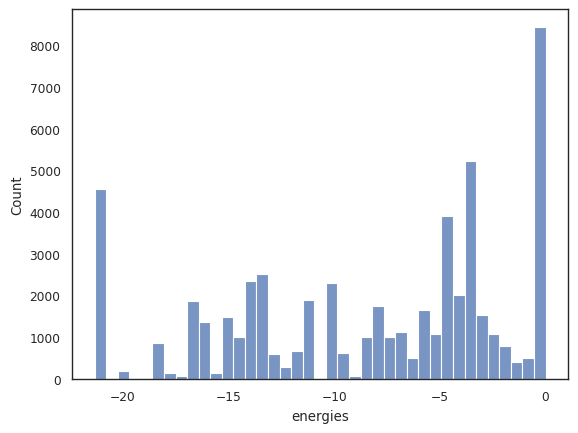

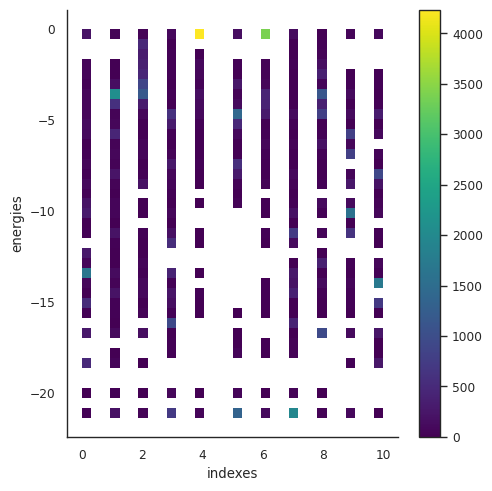

In [ ]:
# Collect all energies with indexes in list from slide_df and plot distribution
energies = []
indexes = []
for i, row in slide_df.iterrows():
    energies_i = row["energies"]
    energies += energies_i
    indexes_i = list(range(0, 11))
    indexes += indexes_i

sns.histplot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="energies",
)

sns.displot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="indexes",
    y="energies",
    cmap="viridis",
    rug=False,
    cbar=True,
)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scip

FileNotFoundError: [Errno 2] No such file or directory: '../data/MiniAbsolut/1ADQ/energy_contributions/high_test_5000_absolut_energy_contributions.tsv'

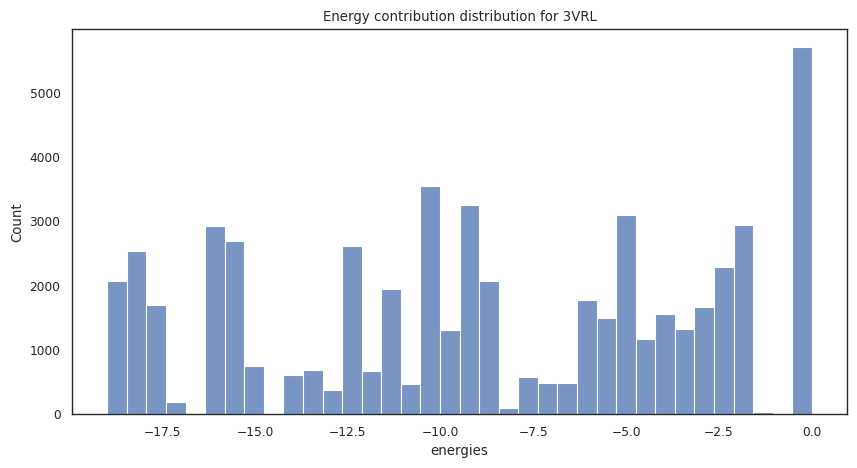

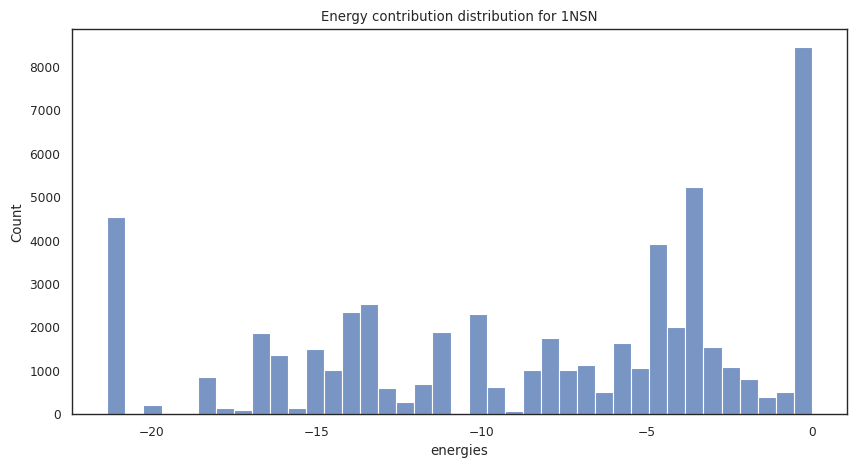

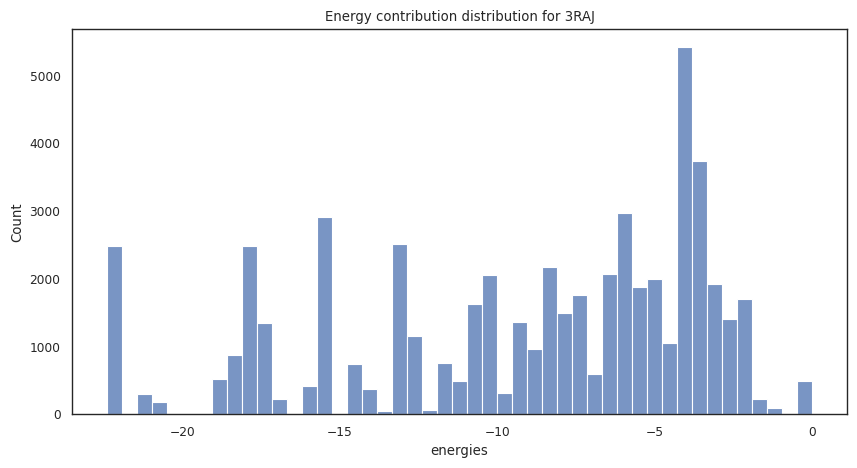

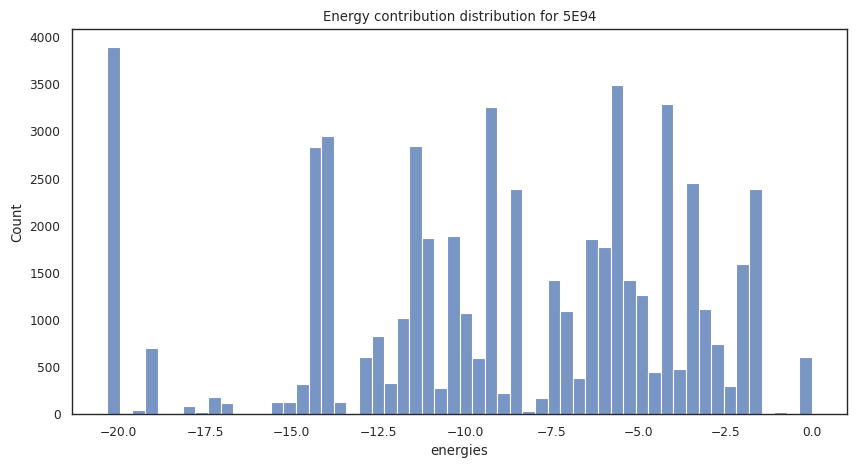

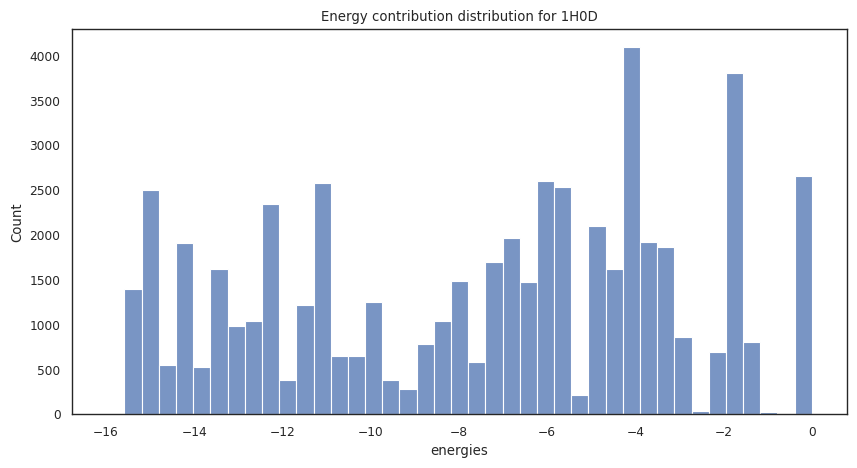

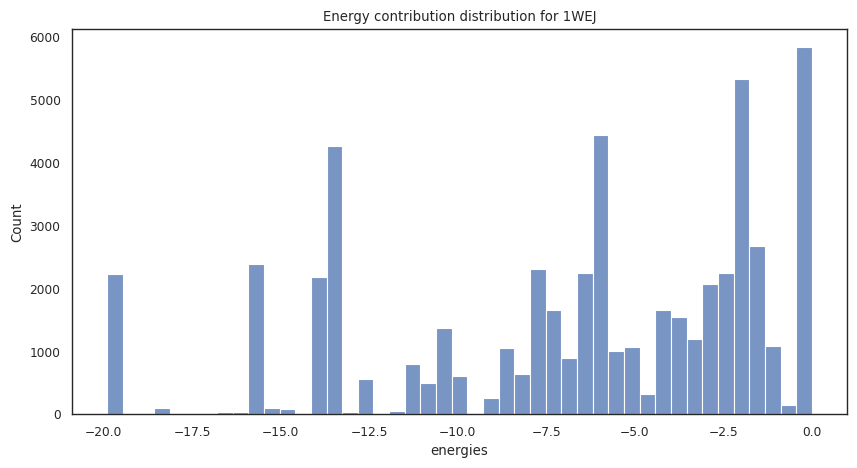

In [ ]:
for ag in config.ANTIGENS:
    task = datasets.ClassificationTask(
        task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
        ag_pos=ag,
        ag_neg="auto",
        seed_id=0,
        split_id=42,
    )
    _, slide_df = load_energy_contributions_from_task_nonlinear_version(task, load_slide_df=True)
    
    energies = []
    indexes = []
    for i, row in slide_df.iterrows():
        energies_i = row["energies"]
        energies += energies_i
        indexes_i = list(range(0, 11))
        indexes += indexes_i

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(
        data=pd.DataFrame({"energies": energies, "indexes": indexes}),
        x="energies",
    )
    ax.set_title(f"Energy contribution distribution for {ag}")